In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('GOOGL.csv')
df = df[['Date', 'Close']]
df = df.rename({'Close': 'Price'}, axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,Price
Date,
2021-02-08,2084.520020
2021-02-09,2075.389893
2021-02-10,2086.479980
2021-02-11,2088.750000
2021-02-12,2095.030029
...,...
2022-02-01,2752.879883
2022-02-02,2960.000000
2022-02-03,2861.800049


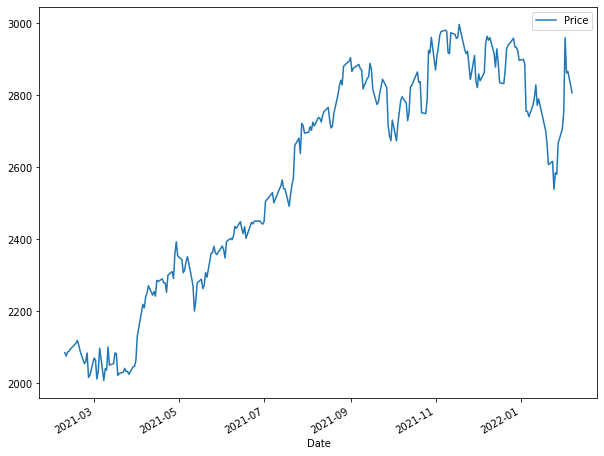

In [5]:
df.plot(figsize=(10,8))

In [6]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int, 
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for layer in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='Theta_Layer')

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    
    theta = self.theta_layer(x)
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]

    return backcast, forecast

In [7]:
EPOCHS = 2000
N_NEURONS = 512
N_LAYERS = 8
N_STACKS = 30

WINDOW_SIZE = 7
HORIZON = 1

INPUT_SIZE = WINDOW_SIZE
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [8]:
nbeats_data = df.copy()

for i in range(WINDOW_SIZE):
  nbeats_data[f'Price{i+1}'] = nbeats_data['Price'].shift(periods=i+1)

nbeats_data = nbeats_data.dropna()

nbeats_data

,Price,Price1,Price2,Price3,Price4,Price5,Price6,Price7
Date,,,,,,,,
2021-02-18,2105.810059,2118.620117,2110.699951,2095.030029,2088.750000,2086.479980,2075.389893,2084.520020
2021-02-19,2088.810059,2105.810059,2118.620117,2110.699951,2095.030029,2088.750000,2086.479980,2075.389893
2021-02-22,2054.260010,2088.810059,2105.810059,2118.620117,2110.699951,2095.030029,2088.750000,2086.479980
2021-02-23,2060.120117,2054.260010,2088.810059,2105.810059,2118.620117,2110.699951,2095.030029,2088.750000
2021-02-24,2083.810059,2060.120117,2054.260010,2088.810059,2105.810059,2118.620117,2110.699951,2095.030029
...,...,...,...,...,...,...,...,...
2022-02-01,2752.879883,2706.070068,2667.020020,2580.100098,2584.659912,2538.699951,2616.080078,2607.030029
2022-02-02,2960.000000,2752.879883,2706.070068,2667.020020,2580.100098,2584.659912,2538.699951,2616.080078
2022-02-03,2861.800049,2960.000000,2752.879883,2706.070068,2667.020020,2580.100098,2584.659912,2538.699951


In [9]:
X = nbeats_data.drop("Price", axis=1)
y = nbeats_data['Price']

In [ ]:
X

,Price1,Price2,Price3,Price4,Price5,Price6,Price7
Date,,,,,,,
2021-02-18,2118.620117,2110.699951,2095.030029,2088.750000,2086.479980,2075.389893,2084.520020
2021-02-19,2105.810059,2118.620117,2110.699951,2095.030029,2088.750000,2086.479980,2075.389893
2021-02-22,2088.810059,2105.810059,2118.620117,2110.699951,2095.030029,2088.750000,2086.479980
2021-02-23,2054.260010,2088.810059,2105.810059,2118.620117,2110.699951,2095.030029,2088.750000
2021-02-24,2060.120117,2054.260010,2088.810059,2105.810059,2118.620117,2110.699951,2095.030029
...,...,...,...,...,...,...,...
2022-02-01,2706.070068,2667.020020,2580.100098,2584.659912,2538.699951,2616.080078,2607.030029
2022-02-02,2752.879883,2706.070068,2667.020020,2580.100098,2584.659912,2538.699951,2616.080078
2022-02-03,2960.000000,2752.879883,2706.070068,2667.020020,2580.100098,2584.659912,2538.699951


In [10]:
y

Date
2021-02-18    2105.810059
2021-02-19    2088.810059
2021-02-22    2054.260010
2021-02-23    2060.120117
2021-02-24    2083.810059
                 ...     
2022-02-01    2752.879883
2022-02-02    2960.000000
2022-02-03    2861.800049
2022-02-04    2865.860107
2022-02-07    2806.760010
Name: Price, Length: 246, dtype: float64

In [11]:
split_size = int(len(X) * 0.8)

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(196, 196, 50, 50)

In [12]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 32

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [13]:
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

In [14]:
nbeats_predictor = NBeatsBlock(input_size=INPUT_SIZE,
                               theta_size=THETA_SIZE,
                               horizon=HORIZON,
                               n_neurons=N_NEURONS,
                               n_layers=N_LAYERS,
                               name='nbeats_block_00')

stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name='stack_input')

backcast, forecast = nbeats_predictor(stack_input)

residuals = tf.keras.layers.subtract([stack_input, backcast], name='subtract_00')


for i, _ in enumerate(range(N_STACKS-1)):
  backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                         theta_size=THETA_SIZE,
                                         horizon=HORIZON,
                                         n_neurons=N_NEURONS,
                                         n_layers=N_LAYERS,
                                         name=f"nbeats_block_{i}")(residuals)

  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f'add_{i}')


model = tf.keras.Model(inputs=stack_input, outputs=forecast, name='nbeats_model')

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['mae', 'mse'])


model.fit(train_dataset, 
          epochs=EPOCHS, 
          validation_data=test_dataset,
          callbacks=[create_model_checkpoint(model_name=model.name)])


Epoch 1/2000
7/7 [==============================] - ETA: 0s - loss: 3238.3374 - mae: 3238.3374 - mse: 25358214.0000

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 47s 5s/step - loss: 3238.3374 - mae: 3238.3374 - mse: 25358214.0000 - val_loss: 933.7237 - val_mae: 933.7237 - val_mse: 878755.8125
Epoch 2/2000
6/7 [========================>.....] - ETA: 0s - loss: 1431.8136 - mae: 1431.8136 - mse: 6891899.5000

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 36s 6s/step - loss: 1407.2209 - mae: 1407.2209 - mse: 6752313.0000 - val_loss: 587.4592 - val_mae: 587.4592 - val_mse: 350447.0000
Epoch 3/2000
7/7 [==============================] - ETA: 0s - loss: 425.2150 - mae: 425.2150 - mse: 196970.7188

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 425.2150 - mae: 425.2150 - mse: 196970.7188 - val_loss: 209.2385 - val_mae: 209.2385 - val_mse: 49427.5664
Epoch 4/2000
7/7 [==============================] - ETA: 0s - loss: 200.2075 - mae: 200.2075 - mse: 46737.3008

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 200.2075 - mae: 200.2075 - mse: 46737.3008 - val_loss: 78.4042 - val_mae: 78.4042 - val_mse: 9117.2578
Epoch 5/2000
7/7 [==============================] - ETA: 0s - loss: 54.7381 - mae: 54.7381 - mse: 4723.7710

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 54.7381 - mae: 54.7381 - mse: 4723.7710 - val_loss: 60.8571 - val_mae: 60.8571 - val_mse: 6539.7656
Epoch 6/2000
7/7 [==============================] - 0s 58ms/step - loss: 68.4046 - mae: 68.4046 - mse: 8154.1069 - val_loss: 202.6720 - val_mae: 202.6720 - val_mse: 46161.7383
Epoch 7/2000
7/7 [==============================] - 0s 49ms/step - loss: 119.6267 - mae: 119.6267 - mse: 19752.6094 - val_loss: 161.1872 - val_mae: 161.1872 - val_mse: 31240.5449
Epoch 8/2000
7/7 [==============================] - 0s 53ms/step - loss: 85.3446 - mae: 85.3446 - mse: 10176.1689 - val_loss: 167.5997 - val_mae: 167.5997 - val_mse: 35124.3359
Epoch 9/2000
7/7 [==============================] - 0s 46ms/step - loss: 112.7301 - mae: 112.7301 - mse: 16478.1309 - val_loss: 65.0658 - val_mae: 65.0658 - val_mse: 6757.6626
Epoch 10/2000
7/7 [==============================] - 0s 46ms/step - loss: 79.7438 - mae: 79.7438 - mse: 10349.0469 - val_loss: 194.79

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 30s 5s/step - loss: 57.7285 - mae: 57.7285 - mse: 4534.9023 - val_loss: 58.7374 - val_mae: 58.7374 - val_mse: 6217.3633
Epoch 30/2000
7/7 [==============================] - 0s 53ms/step - loss: 68.0535 - mae: 68.0535 - mse: 6607.5898 - val_loss: 62.9007 - val_mae: 62.9007 - val_mse: 7106.1924
Epoch 31/2000
7/7 [==============================] - 0s 48ms/step - loss: 79.0986 - mae: 79.0986 - mse: 8629.9941 - val_loss: 66.8025 - val_mae: 66.8025 - val_mse: 7112.6836
Epoch 32/2000
7/7 [==============================] - 0s 47ms/step - loss: 63.0425 - mae: 63.0425 - mse: 5599.1172 - val_loss: 60.0856 - val_mae: 60.0856 - val_mse: 6310.4175
Epoch 33/2000
7/7 [==============================] - ETA: 0s - loss: 63.8584 - mae: 63.8584 - mse: 5707.7734

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 29s 5s/step - loss: 63.8584 - mae: 63.8584 - mse: 5707.7734 - val_loss: 58.3873 - val_mae: 58.3873 - val_mse: 6094.3638
Epoch 34/2000
7/7 [==============================] - ETA: 0s - loss: 65.1255 - mae: 65.1255 - mse: 5877.8955

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 29s 5s/step - loss: 65.1255 - mae: 65.1255 - mse: 5877.8955 - val_loss: 57.7164 - val_mae: 57.7164 - val_mse: 5918.6587
Epoch 35/2000
6/7 [========================>.....] - ETA: 0s - loss: 63.0771 - mae: 63.0771 - mse: 5580.5249

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 63.8199 - mae: 63.8199 - mse: 5680.2896 - val_loss: 57.6907 - val_mae: 57.6907 - val_mse: 5814.8735
Epoch 36/2000
7/7 [==============================] - 0s 52ms/step - loss: 66.6789 - mae: 66.6789 - mse: 6278.5942 - val_loss: 61.2984 - val_mae: 61.2984 - val_mse: 6208.4502
Epoch 37/2000
7/7 [==============================] - ETA: 0s - loss: 59.5385 - mae: 59.5385 - mse: 5004.5005

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 59.5385 - mae: 59.5385 - mse: 5004.5005 - val_loss: 57.1805 - val_mae: 57.1805 - val_mse: 5791.1479
Epoch 38/2000
7/7 [==============================] - 0s 55ms/step - loss: 60.4815 - mae: 60.4815 - mse: 5185.3721 - val_loss: 57.6594 - val_mae: 57.6594 - val_mse: 5859.0923
Epoch 39/2000
7/7 [==============================] - ETA: 0s - loss: 61.4946 - mae: 61.4946 - mse: 5322.0654

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 61.4946 - mae: 61.4946 - mse: 5322.0654 - val_loss: 56.5548 - val_mae: 56.5548 - val_mse: 5742.4907
Epoch 40/2000
7/7 [==============================] - 0s 51ms/step - loss: 60.6957 - mae: 60.6957 - mse: 5172.5977 - val_loss: 56.9338 - val_mae: 56.9338 - val_mse: 5706.4761
Epoch 41/2000
7/7 [==============================] - 0s 45ms/step - loss: 64.9892 - mae: 64.9892 - mse: 6025.9805 - val_loss: 75.0898 - val_mae: 75.0898 - val_mse: 8461.9121
Epoch 42/2000
7/7 [==============================] - 0s 45ms/step - loss: 50.1690 - mae: 50.1690 - mse: 3538.9863 - val_loss: 57.7657 - val_mae: 57.7657 - val_mse: 5783.7012
Epoch 43/2000
7/7 [==============================] - 0s 44ms/step - loss: 56.6037 - mae: 56.6037 - mse: 5155.6704 - val_loss: 65.1381 - val_mae: 65.1381 - val_mse: 7455.4980
Epoch 44/2000
7/7 [==============================] - 0s 43ms/step - loss: 66.5151 - mae: 66.5151 - mse: 6565.4141 - val_loss: 101.2383 - val_mae:

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 40.7405 - mae: 40.7405 - mse: 2591.9509 - val_loss: 53.0567 - val_mae: 53.0567 - val_mse: 5052.5527
Epoch 93/2000
7/7 [==============================] - 0s 54ms/step - loss: 52.3735 - mae: 52.3735 - mse: 3954.5049 - val_loss: 64.5927 - val_mae: 64.5927 - val_mse: 7433.6855
Epoch 94/2000
7/7 [==============================] - 0s 47ms/step - loss: 68.1752 - mae: 68.1752 - mse: 6339.8091 - val_loss: 73.2472 - val_mae: 73.2472 - val_mse: 8131.1519
Epoch 95/2000
7/7 [==============================] - 0s 45ms/step - loss: 53.7065 - mae: 53.7065 - mse: 4048.1035 - val_loss: 59.0150 - val_mae: 59.0150 - val_mse: 6189.0063
Epoch 96/2000
7/7 [==============================] - 0s 45ms/step - loss: 62.1625 - mae: 62.1625 - mse: 5555.0605 - val_loss: 65.8114 - val_mae: 65.8114 - val_mse: 7746.5962
Epoch 97/2000
7/7 [==============================] - 0s 45ms/step - loss: 67.4659 - mae: 67.4659 - mse: 6387.4204 - val_loss: 83.3357 - val_mae: 

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 47.8939 - mae: 47.8939 - mse: 3416.5925 - val_loss: 50.5775 - val_mae: 50.5775 - val_mse: 4709.2515
Epoch 112/2000
7/7 [==============================] - 0s 56ms/step - loss: 49.0134 - mae: 49.0134 - mse: 3886.3530 - val_loss: 55.8471 - val_mae: 55.8471 - val_mse: 5762.7749
Epoch 113/2000
7/7 [==============================] - 0s 45ms/step - loss: 38.2971 - mae: 38.2971 - mse: 2538.7324 - val_loss: 58.6281 - val_mae: 58.6281 - val_mse: 6274.3286
Epoch 114/2000
7/7 [==============================] - 0s 45ms/step - loss: 37.4666 - mae: 37.4666 - mse: 2343.7842 - val_loss: 53.3462 - val_mae: 53.3462 - val_mse: 4982.7363
Epoch 115/2000
7/7 [==============================] - 0s 45ms/step - loss: 29.9568 - mae: 29.9568 - mse: 1632.6594 - val_loss: 54.5811 - val_mae: 54.5811 - val_mse: 5384.8154
Epoch 116/2000
7/7 [==============================] - 0s 46ms/step - loss: 46.2849 - mae: 46.2849 - mse: 3205.8108 - val_loss: 62.6306 - val_

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 42.6944 - mae: 42.6944 - mse: 2702.2395 - val_loss: 49.5384 - val_mae: 49.5384 - val_mse: 4429.9067
Epoch 135/2000
7/7 [==============================] - 0s 53ms/step - loss: 47.0198 - mae: 47.0198 - mse: 3284.1968 - val_loss: 74.5931 - val_mae: 74.5931 - val_mse: 8196.7412
Epoch 136/2000
7/7 [==============================] - 0s 44ms/step - loss: 37.6839 - mae: 37.6839 - mse: 2172.9634 - val_loss: 67.2615 - val_mae: 67.2615 - val_mse: 6892.4839
Epoch 137/2000
7/7 [==============================] - 0s 44ms/step - loss: 34.5702 - mae: 34.5702 - mse: 1888.8079 - val_loss: 54.2028 - val_mae: 54.2028 - val_mse: 5009.5205
Epoch 138/2000
7/7 [==============================] - ETA: 0s - loss: 35.7123 - mae: 35.7123 - mse: 2022.1683

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 35.7123 - mae: 35.7123 - mse: 2022.1683 - val_loss: 49.4012 - val_mae: 49.4012 - val_mse: 4773.8174
Epoch 139/2000
7/7 [==============================] - 0s 56ms/step - loss: 49.6709 - mae: 49.6709 - mse: 3481.1550 - val_loss: 59.8198 - val_mae: 59.8198 - val_mse: 5878.7441
Epoch 140/2000
7/7 [==============================] - 0s 44ms/step - loss: 44.2965 - mae: 44.2965 - mse: 2859.6160 - val_loss: 84.4620 - val_mae: 84.4620 - val_mse: 9605.9404
Epoch 141/2000
7/7 [==============================] - 0s 44ms/step - loss: 41.0121 - mae: 41.0121 - mse: 2450.4221 - val_loss: 73.3680 - val_mae: 73.3680 - val_mse: 8087.5425
Epoch 142/2000
7/7 [==============================] - 0s 45ms/step - loss: 35.8005 - mae: 35.8005 - mse: 1995.5208 - val_loss: 56.4419 - val_mae: 56.4419 - val_mse: 5507.2612
Epoch 143/2000
7/7 [==============================] - ETA: 0s - loss: 35.8487 - mae: 35.8487 - mse: 2062.2217

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 35.8487 - mae: 35.8487 - mse: 2062.2217 - val_loss: 49.3600 - val_mae: 49.3600 - val_mse: 4488.0332
Epoch 144/2000
7/7 [==============================] - 0s 55ms/step - loss: 43.2331 - mae: 43.2331 - mse: 2804.6042 - val_loss: 64.4778 - val_mae: 64.4778 - val_mse: 6278.8677
Epoch 145/2000
7/7 [==============================] - 0s 44ms/step - loss: 36.3589 - mae: 36.3589 - mse: 1976.5360 - val_loss: 50.7209 - val_mae: 50.7209 - val_mse: 5014.0024
Epoch 146/2000
7/7 [==============================] - 0s 45ms/step - loss: 44.3569 - mae: 44.3569 - mse: 2956.6128 - val_loss: 52.0760 - val_mae: 52.0760 - val_mse: 4862.6763
Epoch 147/2000
7/7 [==============================] - 0s 44ms/step - loss: 47.4174 - mae: 47.4174 - mse: 3234.2341 - val_loss: 89.3575 - val_mae: 89.3575 - val_mse: 10697.5352
Epoch 148/2000
7/7 [==============================] - 0s 46ms/step - loss: 39.7826 - mae: 39.7826 - mse: 2391.6309 - val_loss: 59.0039 - val

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 37.8434 - mae: 37.8434 - mse: 2219.1064 - val_loss: 47.7657 - val_mae: 47.7657 - val_mse: 4162.7520
Epoch 164/2000
7/7 [==============================] - 0s 52ms/step - loss: 44.0123 - mae: 44.0123 - mse: 2884.2563 - val_loss: 48.5391 - val_mae: 48.5391 - val_mse: 4286.6313
Epoch 165/2000
7/7 [==============================] - 0s 42ms/step - loss: 47.8512 - mae: 47.8512 - mse: 3315.1843 - val_loss: 87.6976 - val_mae: 87.6976 - val_mse: 10404.3359
Epoch 166/2000
7/7 [==============================] - 0s 44ms/step - loss: 37.9901 - mae: 37.9901 - mse: 2222.0154 - val_loss: 59.5398 - val_mae: 59.5398 - val_mse: 5754.2139
Epoch 167/2000
7/7 [==============================] - 0s 43ms/step - loss: 30.9625 - mae: 30.9625 - mse: 1603.7572 - val_loss: 50.6416 - val_mae: 50.6416 - val_mse: 4754.3999
Epoch 168/2000
7/7 [==============================] - 0s 45ms/step - loss: 37.1732 - mae: 37.1732 - mse: 2192.6245 - val_loss: 50.2911 - val

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 31.5484 - mae: 31.5484 - mse: 1657.0734 - val_loss: 47.0224 - val_mae: 47.0224 - val_mse: 3939.2458
Epoch 191/2000
7/7 [==============================] - 0s 58ms/step - loss: 37.6073 - mae: 37.6073 - mse: 2217.5769 - val_loss: 49.9713 - val_mae: 49.9713 - val_mse: 4817.8945
Epoch 192/2000
7/7 [==============================] - 0s 44ms/step - loss: 43.6117 - mae: 43.6117 - mse: 2828.6707 - val_loss: 63.0965 - val_mae: 63.0965 - val_mse: 6156.7871
Epoch 193/2000
7/7 [==============================] - ETA: 0s - loss: 37.4432 - mae: 37.4432 - mse: 2112.6362

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 37.4432 - mae: 37.4432 - mse: 2112.6362 - val_loss: 45.6097 - val_mae: 45.6097 - val_mse: 3894.2375
Epoch 194/2000
7/7 [==============================] - 0s 51ms/step - loss: 29.4303 - mae: 29.4303 - mse: 1473.8323 - val_loss: 46.9959 - val_mae: 46.9959 - val_mse: 4202.0708
Epoch 195/2000
7/7 [==============================] - 0s 44ms/step - loss: 34.3256 - mae: 34.3256 - mse: 1958.4882 - val_loss: 49.6048 - val_mae: 49.6048 - val_mse: 4692.7441
Epoch 196/2000
7/7 [==============================] - 0s 45ms/step - loss: 34.9720 - mae: 34.9720 - mse: 2051.3125 - val_loss: 48.8429 - val_mae: 48.8429 - val_mse: 4582.2695
Epoch 197/2000
7/7 [==============================] - 0s 44ms/step - loss: 47.3175 - mae: 47.3175 - mse: 3183.1206 - val_loss: 48.7097 - val_mae: 48.7097 - val_mse: 4264.0068
Epoch 198/2000
7/7 [==============================] - 0s 44ms/step - loss: 48.2406 - mae: 48.2406 - mse: 3319.1826 - val_loss: 94.1021 - val_

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 27.8092 - mae: 27.8092 - mse: 1343.3293 - val_loss: 45.5525 - val_mae: 45.5525 - val_mse: 4086.8362
Epoch 230/2000
7/7 [==============================] - 0s 51ms/step - loss: 35.2613 - mae: 35.2613 - mse: 2004.7582 - val_loss: 62.5522 - val_mae: 62.5522 - val_mse: 6299.2373
Epoch 231/2000
7/7 [==============================] - 0s 43ms/step - loss: 35.0811 - mae: 35.0811 - mse: 1842.8344 - val_loss: 72.5081 - val_mae: 72.5081 - val_mse: 7869.7061
Epoch 232/2000
7/7 [==============================] - 0s 43ms/step - loss: 33.7347 - mae: 33.7347 - mse: 1697.0012 - val_loss: 55.6068 - val_mae: 55.6068 - val_mse: 5206.7964
Epoch 233/2000
7/7 [==============================] - 0s 46ms/step - loss: 31.7629 - mae: 31.7629 - mse: 1648.7360 - val_loss: 58.8372 - val_mae: 58.8372 - val_mse: 5586.3018
Epoch 234/2000
7/7 [==============================] - 0s 45ms/step - loss: 34.5177 - mae: 34.5177 - mse: 1801.6462 - val_loss: 61.5337 - val_

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 40.9473 - mae: 40.9473 - mse: 2611.6917 - val_loss: 45.3890 - val_mae: 45.3890 - val_mse: 3977.7356
Epoch 357/2000
7/7 [==============================] - 0s 53ms/step - loss: 35.2623 - mae: 35.2623 - mse: 1961.0891 - val_loss: 50.8570 - val_mae: 50.8570 - val_mse: 4766.4980
Epoch 358/2000
7/7 [==============================] - 0s 43ms/step - loss: 44.0246 - mae: 44.0246 - mse: 2956.3586 - val_loss: 61.6832 - val_mae: 61.6832 - val_mse: 6185.3340
Epoch 359/2000
7/7 [==============================] - 0s 60ms/step - loss: 38.1043 - mae: 38.1043 - mse: 2243.5403 - val_loss: 54.8724 - val_mae: 54.8724 - val_mse: 5210.7612
Epoch 360/2000
7/7 [==============================] - 0s 48ms/step - loss: 35.6185 - mae: 35.6185 - mse: 2071.4900 - val_loss: 53.1183 - val_mae: 53.1183 - val_mse: 5257.3882
Epoch 361/2000
7/7 [==============================] - 0s 47ms/step - loss: 39.6995 - mae: 39.6995 - mse: 2682.8032 - val_loss: 62.2149 - val_

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 28.0336 - mae: 28.0336 - mse: 1372.8976 - val_loss: 43.2204 - val_mae: 43.2204 - val_mse: 3555.0471
Epoch 406/2000
7/7 [==============================] - 0s 54ms/step - loss: 34.4613 - mae: 34.4613 - mse: 1940.8807 - val_loss: 61.3007 - val_mae: 61.3007 - val_mse: 5925.7476
Epoch 407/2000
7/7 [==============================] - 0s 44ms/step - loss: 33.2289 - mae: 33.2289 - mse: 1721.9094 - val_loss: 54.8608 - val_mae: 54.8608 - val_mse: 5153.5864
Epoch 408/2000
7/7 [==============================] - 0s 45ms/step - loss: 31.7307 - mae: 31.7307 - mse: 1615.6537 - val_loss: 57.3255 - val_mae: 57.3255 - val_mse: 5556.0723
Epoch 409/2000
7/7 [==============================] - 0s 43ms/step - loss: 30.6041 - mae: 30.6041 - mse: 1543.6146 - val_loss: 52.6671 - val_mae: 52.6671 - val_mse: 4822.2437
Epoch 410/2000
7/7 [==============================] - 0s 44ms/step - loss: 31.2501 - mae: 31.2501 - mse: 1625.3298 - val_loss: 49.6957 - val_

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 32.4310 - mae: 32.4310 - mse: 1708.3705 - val_loss: 40.4856 - val_mae: 40.4856 - val_mse: 3307.7764
Epoch 444/2000
7/7 [==============================] - 0s 54ms/step - loss: 27.5178 - mae: 27.5178 - mse: 1342.4578 - val_loss: 45.8636 - val_mae: 45.8636 - val_mse: 3877.1387
Epoch 445/2000
7/7 [==============================] - 0s 47ms/step - loss: 34.5085 - mae: 34.5085 - mse: 1879.1962 - val_loss: 45.0649 - val_mae: 45.0649 - val_mse: 3793.1064
Epoch 446/2000
7/7 [==============================] - 0s 47ms/step - loss: 27.8028 - mae: 27.8028 - mse: 1466.4397 - val_loss: 49.0158 - val_mae: 49.0158 - val_mse: 4447.3110
Epoch 447/2000
7/7 [==============================] - 0s 46ms/step - loss: 40.4837 - mae: 40.4837 - mse: 2457.3137 - val_loss: 66.8911 - val_mae: 66.8911 - val_mse: 8098.4956
Epoch 448/2000
7/7 [==============================] - 0s 44ms/step - loss: 42.6282 - mae: 42.6282 - mse: 2954.8508 - val_loss: 49.8244 - val_

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 28.2048 - mae: 28.2048 - mse: 1334.9380 - val_loss: 39.7691 - val_mae: 39.7691 - val_mse: 3342.1340
Epoch 480/2000
7/7 [==============================] - 0s 50ms/step - loss: 29.7051 - mae: 29.7051 - mse: 1508.7749 - val_loss: 47.4595 - val_mae: 47.4595 - val_mse: 4291.9131
Epoch 481/2000
7/7 [==============================] - 0s 43ms/step - loss: 37.0793 - mae: 37.0793 - mse: 2140.2627 - val_loss: 61.6560 - val_mae: 61.6560 - val_mse: 5903.8711
Epoch 482/2000
7/7 [==============================] - 0s 45ms/step - loss: 32.0638 - mae: 32.0638 - mse: 1606.3542 - val_loss: 50.7990 - val_mae: 50.7990 - val_mse: 4493.7866
Epoch 483/2000
7/7 [==============================] - 0s 45ms/step - loss: 28.9416 - mae: 28.9416 - mse: 1443.0984 - val_loss: 47.2181 - val_mae: 47.2181 - val_mse: 4111.0776
Epoch 484/2000
7/7 [==============================] - 0s 43ms/step - loss: 31.5660 - mae: 31.5660 - mse: 1663.2964 - val_loss: 59.4852 - val_

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 26.2020 - mae: 26.2020 - mse: 1239.7578 - val_loss: 39.6903 - val_mae: 39.6903 - val_mse: 3021.8196
Epoch 721/2000
7/7 [==============================] - 0s 52ms/step - loss: 32.3972 - mae: 32.3972 - mse: 1688.6974 - val_loss: 60.1132 - val_mae: 60.1132 - val_mse: 5598.6660
Epoch 722/2000
7/7 [==============================] - 0s 47ms/step - loss: 31.1117 - mae: 31.1117 - mse: 1559.9156 - val_loss: 44.4957 - val_mae: 44.4957 - val_mse: 3560.5569
Epoch 723/2000
7/7 [==============================] - 0s 47ms/step - loss: 26.5282 - mae: 26.5282 - mse: 1284.0593 - val_loss: 41.4648 - val_mae: 41.4648 - val_mse: 3221.7546
Epoch 724/2000
7/7 [==============================] - 0s 49ms/step - loss: 28.9340 - mae: 28.9340 - mse: 1384.8756 - val_loss: 52.1098 - val_mae: 52.1098 - val_mse: 4604.4126
Epoch 725/2000
7/7 [==============================] - 0s 48ms/step - loss: 30.1496 - mae: 30.1496 - mse: 1433.8293 - val_loss: 50.2276 - val_

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 28s 5s/step - loss: 26.0261 - mae: 26.0261 - mse: 1181.3099 - val_loss: 38.0873 - val_mae: 38.0873 - val_mse: 3346.8362
Epoch 762/2000
7/7 [==============================] - 0s 54ms/step - loss: 28.9663 - mae: 28.9663 - mse: 1384.4266 - val_loss: 44.2980 - val_mae: 44.2980 - val_mse: 3872.7632
Epoch 763/2000
7/7 [==============================] - 0s 51ms/step - loss: 27.9110 - mae: 27.9110 - mse: 1266.4061 - val_loss: 51.1136 - val_mae: 51.1136 - val_mse: 4624.6831
Epoch 764/2000
7/7 [==============================] - 0s 49ms/step - loss: 26.8252 - mae: 26.8252 - mse: 1212.0121 - val_loss: 52.5905 - val_mae: 52.5905 - val_mse: 4770.1934
Epoch 765/2000
7/7 [==============================] - 0s 51ms/step - loss: 28.9184 - mae: 28.9184 - mse: 1349.0408 - val_loss: 48.3745 - val_mae: 48.3745 - val_mse: 4410.1177
Epoch 766/2000
7/7 [==============================] - 0s 49ms/step - loss: 24.6269 - mae: 24.6269 - mse: 1071.7404 - val_loss: 44.6741 - val_

In [15]:
INTO_FUTURE = 14

In [16]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE):

  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    future_forecast.append(tf.squeeze(future_pred).numpy())

    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast


def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")
  return np.arange(start_date, end_date, dtype="datetime64[D]")


def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):

  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

In [17]:
future_forecast = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predicting on: 
 Date
2022-01-28    2667.020020
2022-01-31    2706.070068
2022-02-01    2752.879883
2022-02-02    2960.000000
2022-02-03    2861.800049
2022-02-04    2865.860107
2022-02-07    2806.760010
Name: Price, dtype: float64 -> Prediction: 2706.628662109375

Predicting on: 
 [2706.070068   2752.879883   2960.         2861.800049   2865.860107
 2806.76001    2706.62866211] -> Prediction: 2737.455810546875

Predicting on: 
 [2752.879883   2960.         2861.800049   2865.860107   2806.76001
 2706.62866211 2737.45581055] -> Prediction: 2783.281982421875

Predicting on: 
 [2960.         2861.800049   2865.860107   2806.76001    2706.62866211
 2737.45581055 2783.28198242] -> Prediction: 2924.62744140625

Predicting on: 
 [2861.800049   2865.860107   2806.76001    2706.62866211 2737.45581055
 2783.28198242 2924.62744141] -> Prediction: 2863.919921875

Predicting on: 
 [2865.860107   2806.76001    2706.62866211 2737.45581055 2783.28198242
 2924.62744141 2863.91992188] -> Prediction: 28

In [18]:
last_timestep = nbeats_data.index[-1]
last_timestep

Timestamp('2022-02-07 00:00:00')

In [19]:
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2022-02-08', '2022-02-09', '2022-02-10', '2022-02-11',
       '2022-02-12', '2022-02-13', '2022-02-14', '2022-02-15',
       '2022-02-16', '2022-02-17', '2022-02-18', '2022-02-19',
       '2022-02-20', '2022-02-21'], dtype='datetime64[D]')

In [20]:
y_copy = y.copy()

In [21]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, y[-1])
next_time_steps, future_forecast

(array(['2022-02-07', '2022-02-08', '2022-02-09', '2022-02-10',
        '2022-02-11', '2022-02-12', '2022-02-13', '2022-02-14',
        '2022-02-15', '2022-02-16', '2022-02-17', '2022-02-18',
        '2022-02-19', '2022-02-20', '2022-02-21'], dtype='datetime64[D]'),
 array([2806.76  , 2706.6287, 2737.4558, 2783.282 , 2924.6274, 2863.92  ,
        2863.3616, 2814.2947, 2742.618 , 2761.6604, 2806.6243, 2904.689 ,
        2866.6367, 2859.0518, 2823.0986], dtype=float32))

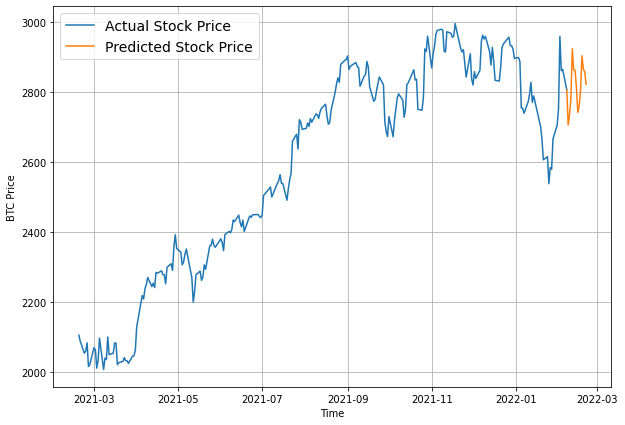

In [22]:
plt.figure(figsize=(10, 7))
plot_time_series(nbeats_data.index, y, format="-", label="Actual Stock Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted Stock Price")

In [23]:
model.save('NBeats Model')

INFO:tensorflow:Assets written to: NBeats Model/assets


INFO:tensorflow:Assets written to: NBeats Model/assets
